In [7]:
imgpath = 'G:\\acra\\NLMCXR_png\\'

In [34]:
imgpathbw = 'G:\\acra\\NLMCXR_png_bw\\'

In [1]:
import cv2
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint, EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input, Conv2D, MaxPooling2D
from keras.optimizers import Adam, Adadelta
from keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.
C:\Users\narayanan\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\narayanan\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\narayanan\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\narayanan\anaconda3\lib\site-packages\tensorflow\python\fra

In [25]:
imglung = pd.DataFrame(glob(imgpath+"*.png"),columns=["Filename"])

In [26]:
filecount = len(imglung)
print(filecount)

7470


In [27]:
imglung.head(3)

,Filename
0,G:\acra\NLMCXR_png\CXR1000_IM-0003-1001.png
1,G:\acra\NLMCXR_png\CXR1000_IM-0003-2001.png
2,G:\acra\NLMCXR_png\CXR1000_IM-0003-3001.png


In [35]:
lungids = pd.DataFrame(imglung["Filename"].str.split('\\').str[3])

'G:\\acra\\NLMCXR_png\\CXR1000_IM-0003-1001.png'

In [32]:
lunglist = list(lungids.Filename.values)
print(lunglist[0])

CXR1000_IM-0003-1001.png


### Images Edge Enhancement - Preprocessing For Classification

In [42]:
def read_convert(filename):
    # load image from file
    pixels=cv2.imread(imgpath+filename,0)
    (thresh, blackAndWhiteImage) = cv2.threshold(pixels, 125, 255, cv2.THRESH_BINARY)
    #plt.imshow(blackAndWhiteImage)
    plt.imsave(imgpathbw+filename,blackAndWhiteImage)

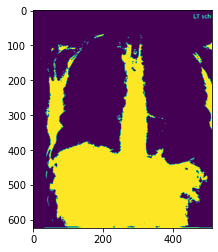

In [41]:
#read_convert(lunglist[0])

In [43]:
%%time
for image in lunglist:
    read_convert(image)

Wall time: 6min 17s


In [45]:
imglung = pd.DataFrame(glob(imgpathbw+"*.png"),columns=["Filename"])
imglung.head(3)

,Filename
0,G:\acra\NLMCXR_png_bw\CXR1000_IM-0003-1001.png
1,G:\acra\NLMCXR_png_bw\CXR1000_IM-0003-2001.png
2,G:\acra\NLMCXR_png_bw\CXR1000_IM-0003-3001.png


In [47]:
lungids = pd.DataFrame(imglung["Filename"].str.split('\\').str[3])
lungids.to_csv("Lung.csv",index=None)

### Lung Classifier to PA and LA

In [82]:
## Around 100 images manually labelled as LA and PA class for model training
labels = pd.read_csv('Lung_100.csv')

In [83]:
labels.head(2)

,Filename,Class
0,CXR1000_IM-0003-1001.png,PA
1,CXR1000_IM-0003-2001.png,LA


In [119]:
ind = labels[(labels.Class == 'PA')].index
labels.loc[ind,'Class'] = 0
ind = labels[(labels.Class == 'LA')].index
labels.loc[ind,'Class'] = 1
labels.head(3)

,Filename,Class
0,CXR1000_IM-0003-1001.png,0
1,CXR1000_IM-0003-2001.png,1
2,CXR1000_IM-0003-3001.png,0


In [84]:
ids = list(labels.Filename)
ids[0:3]

['CXR1000_IM-0003-1001.png',
 'CXR1000_IM-0003-2001.png',
 'CXR1000_IM-0003-3001.png']

In [98]:
def sharpen_image(image):
    #image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_medianblur = cv2.medianBlur(image,3)
    image_sharp = cv2.addWeighted(image_medianblur, 1.5, image_medianblur, -0.5, 0)
    #plt.imshow(image_sharp)
    return image_sharp

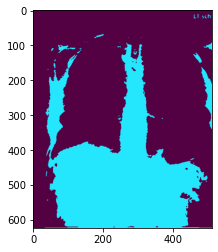

In [93]:
sharpen_image(ids[0])

In [101]:
%%time
X_train = list()

for i in range(len(ids)):
    img = cv2.imread(imgpathbw+ids[i])
    img = cv2.resize(img,dsize=(256,256))
    img_stack = sharpen_image(img)
    X_train.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))

X_train = np.array(X_train)

Wall time: 467 ms


In [102]:
print(len(X_train))

99


In [112]:
X_train.shape

(99, 256, 256, 6)

In [120]:
labels_value = to_categorical(labels["Class"], num_classes = 2)
y_train = labels_value

In [124]:
x_train, x_val, y_train, y_val = train_test_split(X_train, labels_value, test_size = 0.2, random_state=10)

In [126]:
def buildModel():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 6), kernel_initializer = "uniform"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), kernel_initializer = "uniform"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=.00025), metrics=['accuracy'])
    return model

In [143]:
model = buildModel()

In [144]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 254, 254, 32)      1760      
_________________________________________________________________
batch_normalization_7 (Batch (None, 254, 254, 32)      128       
_________________________________________________________________
activation_7 (Activation)    (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 125, 125, 32)      128       
_________________________________________________________________
activation_8 (Activation)    (None, 125, 125, 32)     

In [145]:
early_stopping = EarlyStopping(monitor='val_accuracy',verbose=1,mode='max',patience=5)
check_point = ModelCheckpoint('best_model.h5',save_best_only=True,monitor='val_accuracy',mode='max')

In [146]:
model.fit(x_train,y_train,epochs=10,validation_data=(x_val,y_val),verbose=1,callbacks=[early_stopping,check_point])

Train on 79 samples, validate on 20 samples
Epoch 1/10
79/79 [==============================] - 15s 196ms/step - loss: 3.0296 - accuracy: 0.5949 - val_loss: 1.0476e-06 - val_accuracy: 1.0000
Epoch 2/10
79/79 [==============================] - 17s 215ms/step - loss: 0.2317 - accuracy: 0.9494 - val_loss: 1.0079 - val_accuracy: 0.8500
Epoch 3/10
79/79 [==============================] - 16s 203ms/step - loss: 0.1060 - accuracy: 0.9873 - val_loss: 7.9203e-04 - val_accuracy: 1.0000
Epoch 4/10
79/79 [==============================] - 18s 231ms/step - loss: 1.4335e-08 - accuracy: 1.0000 - val_loss: 2.5630e-07 - val_accuracy: 1.0000
Epoch 5/10
79/79 [==============================] - 19s 241ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
79/79 [==============================] - 18s 232ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 00006: early stopping


### Classifying All X Ray Images Using The Above Model

In [148]:
labels = pd.read_csv('Lung.csv')

In [149]:
ids = list(labels.Filename)
ids[0:3]

['CXR1000_IM-0003-1001.png',
 'CXR1000_IM-0003-2001.png',
 'CXR1000_IM-0003-3001.png']

In [150]:
X_test = []
for i in range(len(ids)):
    img = cv2.imread(path_bw+ids[i])
    img = cv2.resize(img,dsize=(256,256))
    img_stack = sharpen_image(img)
    X_test.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))

In [152]:
y_pred = model.predict_classes(np.array(X_test))

In [154]:
labels['Class'] = y_pred

In [157]:
labels.sample(10)

,Filename,Class
6571,CXR573_IM-2171-12012.png,0
4282,CXR3090_IM-1445-1001.png,0
1765,CXR1855_IM-0555-1001.png,0
5920,CXR3862_IM-1956-2001.png,0
4428,CXR3159_IM-1487-1001-0002.png,1
4948,CXR3402_IM-1646-2001.png,1
4516,CXR3200_IM-1512-2001.png,1
6324,CXR450_IM-2082-2001.png,1
3232,CXR2567_IM-1069-2002.png,0
4924,CXR3391_IM-1637-1001.png,1


In [158]:
imagepa = labels[(labels.Class == 0)]
imagela = labels[(labels.Class == 1)]

In [159]:
imagepa.to_csv('ImagesPA.csv',index=None)
imagela.to_csv('ImagesLA.csv',index=None)

In [2]:
imagela = pd.read_csv('ImagesLA.csv')

In [3]:
imagela.head(2)

,Filename,Class
0,CXR1000_IM-0003-2001.png,1
1,CXR1001_IM-0004-1002.png,1


In [4]:
files = list(imagela.Filename.values)

In [5]:
import shutil

In [6]:
lapath = 'G:\\acra\\NLMCXR_LA_png\\'

In [8]:
for file in files:
    shutil.move(imgpath+file,lapath)